# Implementing custom kernels in Gaussian Processes 

### **Goals:** 
1. Derive analytical (or quasi-analytical) expressions for the autocovariance for the models in [Tacchella, Caplar and Forbes (2020)](https://arxiv.org/pdf/2006.09382.pdf).
2. Implement these as kernels in a Gaussian Process formalism
3. Integrate this with the GP-SFH formalism
3. Sample SFHs with different kernels to see how they are different
3. Run them through FSPS to see how the spectra are different - **are there any observable signatures that can be used to constrain the timescales in the model** (which, in this formalism, act as hyperparameters)? 
4. (**Stretch goal**): Estimate the time-scales for $t_x, t_{eq}, t_L$ from observations in a hyperparameter tuning experiment. What's the optimal dataset for this? How do we solve the problem of timescales going beyond the range of sensitivity (to either long or short frequencies) from the observations?
4. (**Stretch goal**): Probe ergodicity: do these timescales vary with epoch? Does the timescale for an ensemble of galaxies at a given epoch match the timescale for individual galaxies across cosmic time?

Josh did part (1), this notebook is focused on implementing part (2).

Additional notes:

- currently implementing these as stationary kernels. Since a sum/product of GPs are also GPs (mostly), we can modify these in the future to add additional physics or sources of (weak) non-stationarity. 
- I haven't checked that the autocovariances for the regulator models are valid GP kernels yet, but they should be (modulo some edge cases and normalisation factors). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=1.8)
sns.set_style('white')

In [2]:
# Creating a base class that simplifies a lot of things. 
# The way this is set up, you can pass a kernel as an argument 
# to compute the covariance matrix and draw samples from it. 

class simple_GP_sfh():
    
    """
    A class that creates and holds information about a specific 
    kernel, and can generate samples from it.
    
    Attributes
    ----------
    tarr: fiducial time array used to draw samples
    kernel: accepts an input function as an argument,
        of the format:
        
            def kernel_function(delta_t, **kwargs):
                ... function interior ...
                return kernel_val[array of len(delta_t)]
    
    Methods
    -------
    get_covariance_matrix 
        [although this has double for loops for maximum flexibility 
        with generic kernel functions, it only has to be computed once,
        which makes drawing random samples super fast once it's computed.]
    sample_kernel
    plot_samples
    plot_kernel
    [to-do] condition on data
    
    """
    
    def __init__(self):
        
        self.tarr = np.linspace(0,10,1000)
        self.kernel = []
        self.covariance_matrix = []

    def get_covariance_matrix(self, **kwargs):
        """
        Evaluate covariance matrix with a particular kernel
        """
            
        cov_matrix = np.zeros((len(self.tarr),len(self.tarr)))
        for i in range(len(cov_matrix)):
            for j in range(len(cov_matrix)):
                    cov_matrix[i,j] = self.kernel(self.tarr[i] - self.tarr[j], **kwargs)
                    
        return cov_matrix
    
    def sample_kernel(self, nsamp = 100, random_seed = 42, **kwargs):
        
        mean_array = np.zeros_like(self.tarr)
        if len(self.covariance_matrix) == 0:
            self.covariance_matrix = self.get_covariance_matrix(**kwargs)
#         else: 
#             print('using precomputed covariance matrix')
            
        np.random.seed(random_seed)
        samples = np.random.multivariate_normal(mean_array,self.covariance_matrix,size=nsamp)
        
        return samples
    
    def plot_samples(self, nsamp = 100, random_seed = 42, plot_samples=5,plim=2, plotlog=False, **kwargs):
        
        samples = self.sample_kernel(nsamp = nsamp, random_seed = random_seed, **kwargs)
        
        plt.figure(figsize=(12,6))
        if plotlog == True:
            plt.plot(self.tarr, 10**samples.T[0:,0:plot_samples],'-',alpha=0.7,lw=1)
            plt.plot(self.tarr, 10**np.nanpercentile(samples.T,50,axis=1),'k',lw=3,label='median')
            plt.xlabel('time [arbitrary units]')
            plt.ylabel('some quantity of interest')
        else:
            plt.plot(self.tarr, samples.T[0:,0:plot_samples],'-',alpha=0.7,lw=1)
            plt.plot(self.tarr, np.nanpercentile(samples.T,50,axis=1),'k',lw=3,label='median')
            plt.fill_between(self.tarr, np.nanpercentile(samples.T,16,axis=1), 
                            np.nanpercentile(samples.T,84,axis=1),color='k',alpha=0.1,label='1$\sigma$')
            plt.xlabel('time [arbitrary units]')
            plt.ylabel('some quantity of interest')
            plt.legend(edgecolor='w');
            plt.ylim(-plim,plim);plt.title([kwargs])
        plt.show()
        
    def plot_kernel(self, deltat = np.round(np.arange(-10,10,0.1),1), **kwargs):
        
        plt.figure(figsize=(12,6))
        plt.plot(deltat, self.kernel(deltat, **kwargs),lw=3,
                 label=kwargs)
        plt.xlabel('$\Delta t$')
        plt.ylabel('covariance');plt.title(kwargs)
        #plt.text(-9,0.23,'Past');plt.text(7,0.23,'Future')
        plt.show()


In [3]:
# Trying out the class using a couple of canonical kernels

def squared_exp(delta_t, A, l):
        """
        A basic implementation of the squared exponential kernel, with two parameters:
        A: amplitude, the amount of covariance between two times separated by \Delta t
        l: scale factor, the rate of exponential decay, which sets how quickly the covariance decays
        """

        kernel_val = A**2 * np.exp( -((delta_t**2)/(2*l**2)))
        return kernel_val
    
def periodic_kernel(delta_t, A, p = 1.0):
    """
    A basic implementation of the periodic kernel, with two parameters:
    A: amplitude, the amount of covariance between two times separated by \Delta t
    p: period
    """

    kernel_val = A**2 * np.exp ( - 2* np.sin(np.pi * delta_t / p)**2 )
    return kernel_val

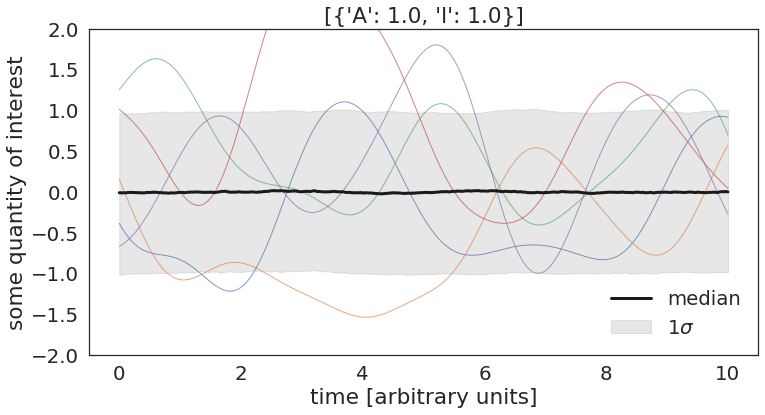

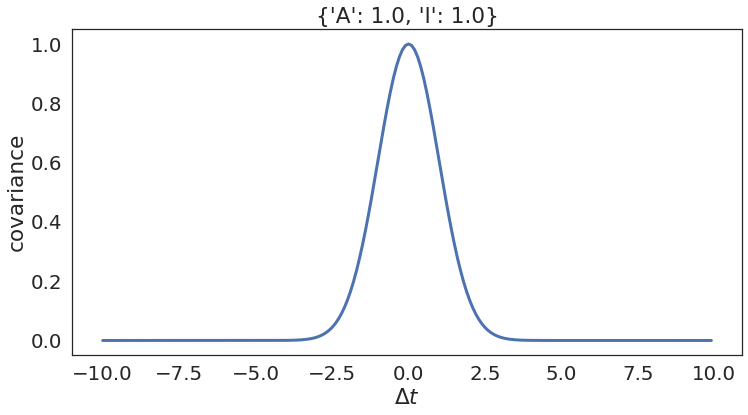

In [4]:
cls1 = simple_GP_sfh()
cls1.kernel = squared_exp
cls1.plot_samples(A=1.0, l = 1.0, nsamp = 10000, random_seed=42)
cls1.plot_kernel(A=1.0, l=1.0)

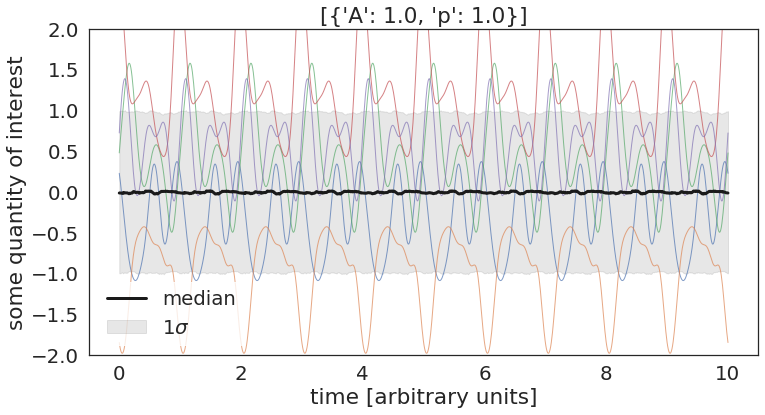

In [5]:
cls1 = simple_GP_sfh()
cls1.kernel = periodic_kernel
cls1.plot_samples(A=1.0, p=1.0, nsamp = 10000, random_seed=42)

# now let's make some custom kernels:

in increasing order of complexity

## 1. White noise

$$
C(\tau) = \delta(\tau)
$$

In [6]:
def white_kernel(delta_t, A=1.0):
    """
    A basic implementation of a white noise kernel, with one (no) parameters:
    A: sigma (not a real parameter in this case)
    """

    kernel_val = np.zeros_like(delta_t)
    kernel_val[delta_t == 0] = A**2
    return kernel_val

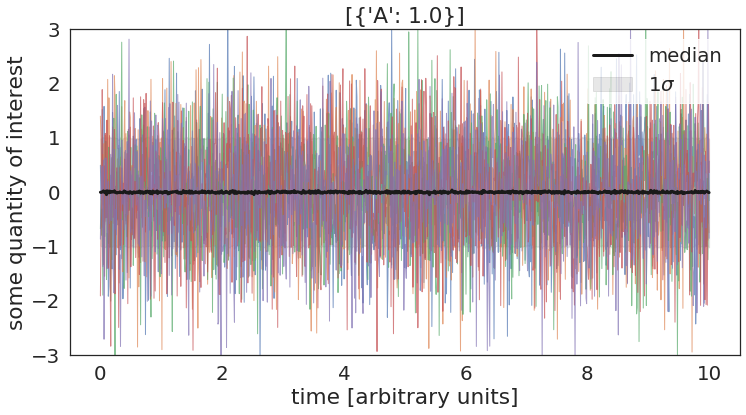

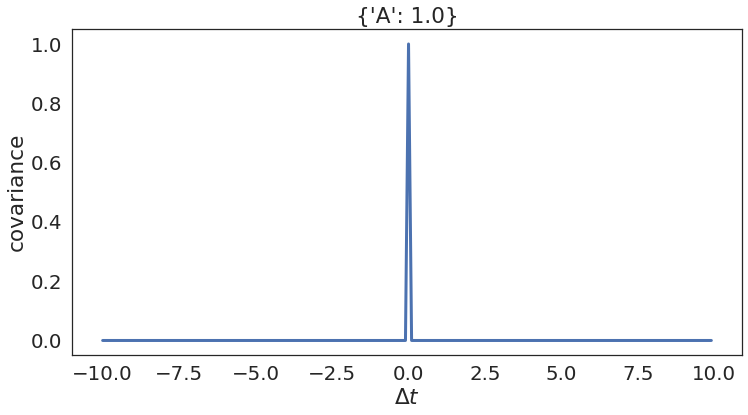

In [7]:
cls1 = simple_GP_sfh()
cls1.kernel = white_kernel
cls1.plot_samples(A=1.0, nsamp = 10000, random_seed=42,plim=3)
cls1.plot_kernel(A=1.0)

## 2. Damped random walk

$$
C(\tau) = \frac{\sigma^2}{2\tau_{eq}} \left( \exp{(-\frac{\tau}{\tau_{eq}})}\right)
$$

In [8]:
def damped_random_walk_kernel(delta_t, sigma=1.0, tau_eq = 1.0):
    """
    A basic implementation of a damped random walk kernel, with two parameters:
    sigma: \sigma, the amount of overall variance
    tau_eq: equilibrium timescale
    
    """

    kernel_val = (sigma**2 / (2*tau_eq)) * np.exp(-np.abs(delta_t) / tau_eq)
    return kernel_val

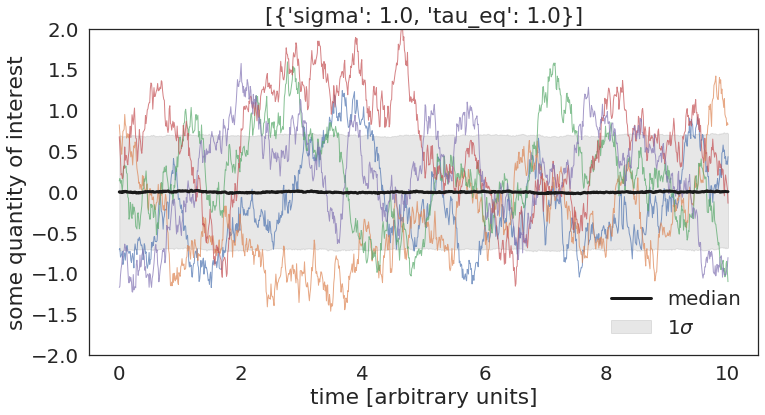

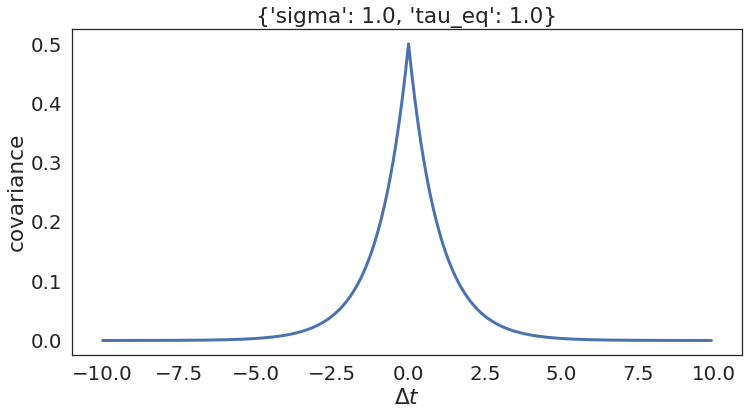

In [9]:
cls1 = simple_GP_sfh()
cls1.kernel = damped_random_walk_kernel
cls1.plot_samples(sigma=1.0, tau_eq=1.0, nsamp = 10000, random_seed=42,plim=2)
cls1.plot_kernel(sigma=1.0, tau_eq=1.0)

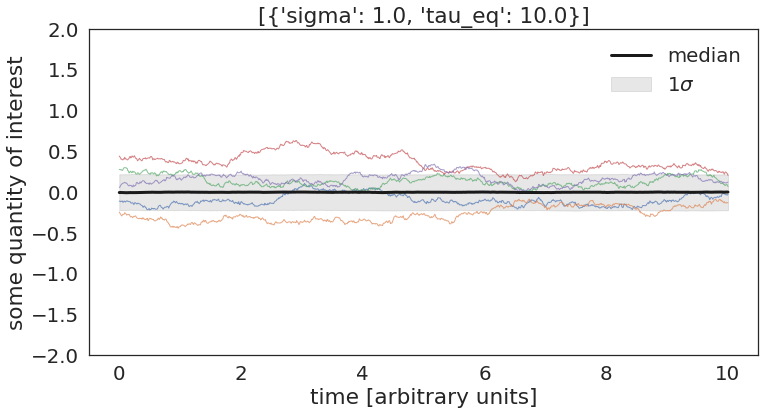

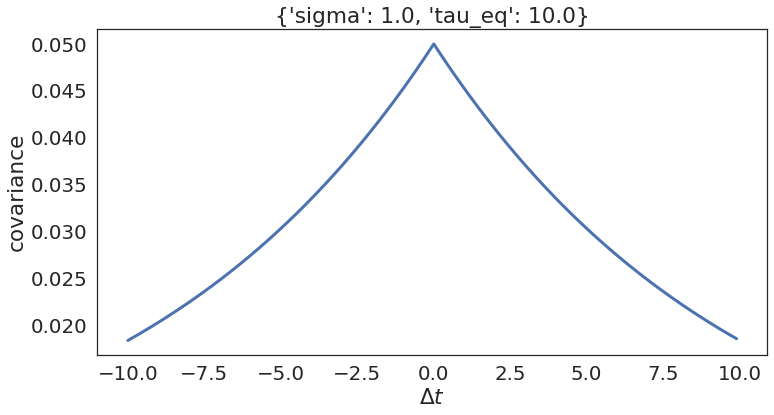

In [10]:
cls1 = simple_GP_sfh()
cls1.kernel = damped_random_walk_kernel
cls1.plot_samples(sigma=1.0, tau_eq=10.0, nsamp = 10000, random_seed=42,plim=2)
cls1.plot_kernel(sigma=1.0, tau_eq=10.0)

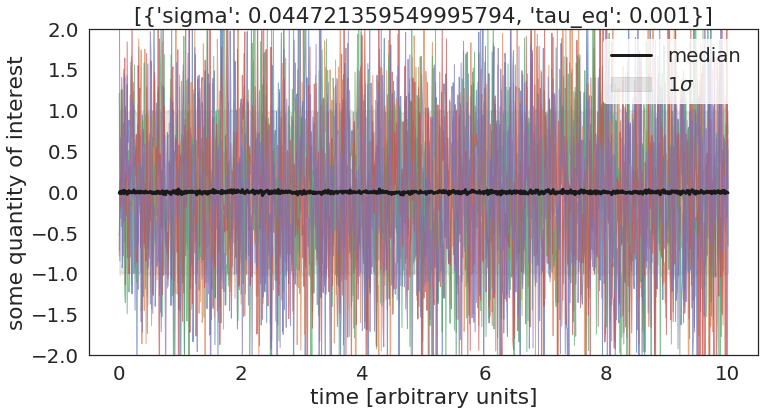

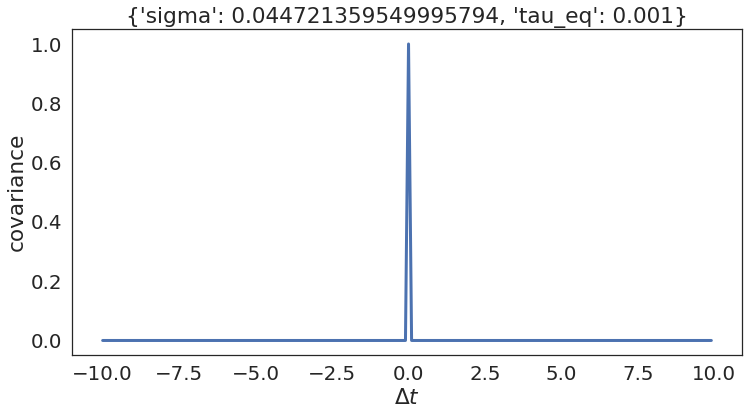

In [11]:
cls1 = simple_GP_sfh()
cls1.kernel = damped_random_walk_kernel
cls1.plot_samples(sigma=1.0/np.sqrt(500), tau_eq=0.001, nsamp = 10000, random_seed=42,plim=2)
cls1.plot_kernel(sigma=1.0/np.sqrt(500), tau_eq=0.001)

## 3. Regulator Model:

For $\tau = |t-t'|$,
$$
C(\tau) = \frac{\sigma^2}{(\tau_x^2 - \tau_{eq}^2)} \left( \tau_x \exp{(-\frac{\tau}{\tau_x})} - \tau_{eq}\exp{(-\frac{\tau}{\tau_{eq}})} \right)
$$

In [12]:
def regulator_model_kernel(delta_t, sigma=1.0, tau_eq = 5.0, tau_x = 0.5):
    """
    A basic implementation of the regulator model kernel, with three parameters:
    sigma: \sigma, the amount of overall variance
    tau_eq: equilibrium timescale
    tau_x: inflow correlation timescale (includes 2pi factor)
    
    """

    kernel_val = sigma**2 / (tau_x**2 - tau_eq**2) * (tau_x * np.exp(-np.abs(delta_t) / tau_x) - tau_eq * np.exp(-np.abs(delta_t) / tau_eq))
    return kernel_val

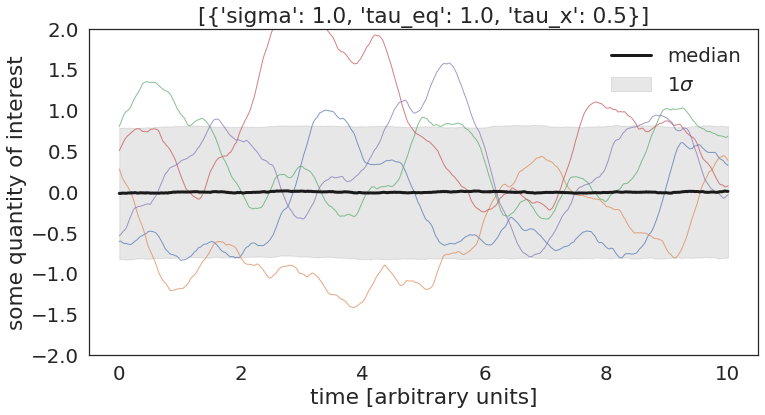

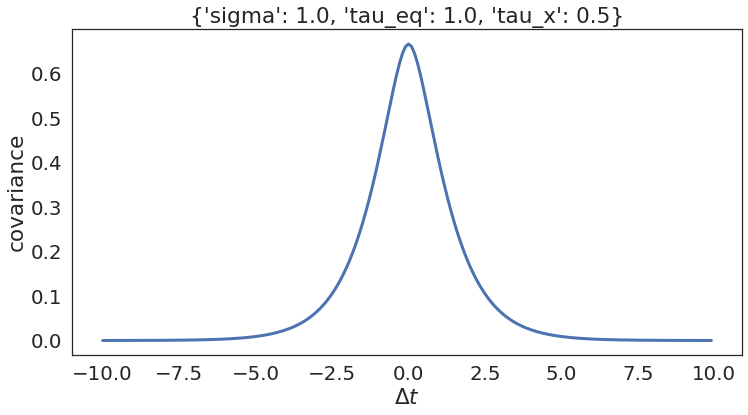

In [13]:
cls1 = simple_GP_sfh()
cls1.kernel = regulator_model_kernel
cls1.plot_samples(sigma=1.0, tau_eq=1.0, tau_x = 0.5, nsamp = 10000, random_seed=42,plim=2)
cls1.plot_kernel(sigma=1.0, tau_eq=1.0, tau_x = 0.5)

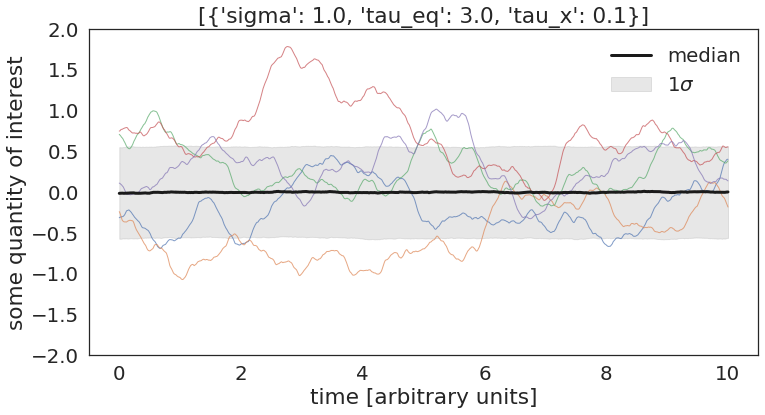

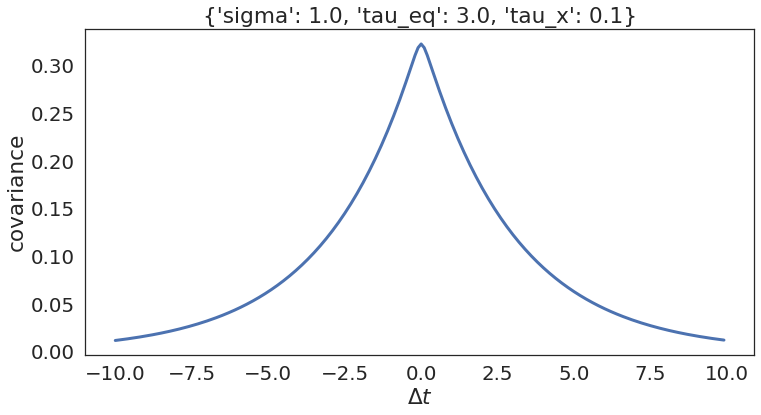

In [14]:
cls1 = simple_GP_sfh()
cls1.kernel = regulator_model_kernel
cls1.plot_samples(sigma=1.0, tau_eq=3.0, tau_x = 0.1, nsamp = 10000, random_seed=42,plim=2)
cls1.plot_kernel(sigma=1.0, tau_eq=3.0, tau_x = 0.1)

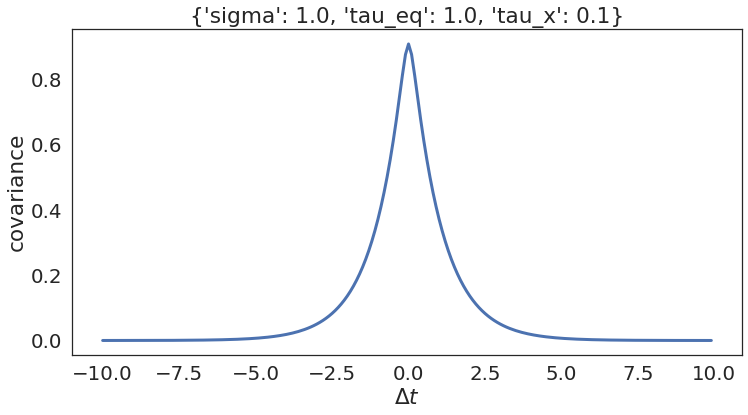

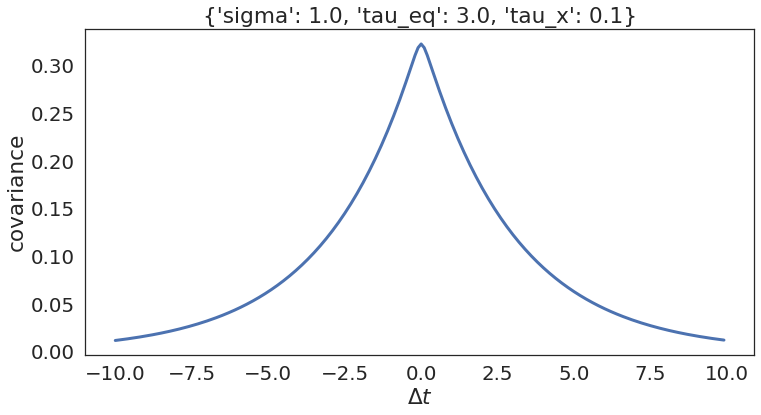

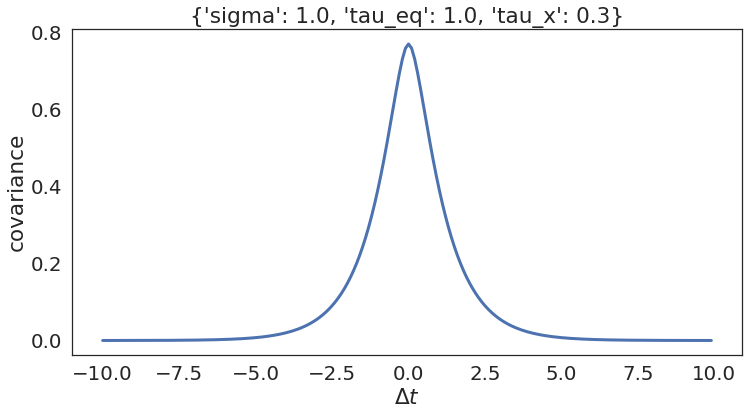

In [15]:
cls1 = simple_GP_sfh()
cls1.kernel = regulator_model_kernel
#cls1.plot_samples(sigma=1.0, tau_eq=3.0, tau_x = 0.1, nsamp = 10000, random_seed=42,plim=2)
cls1.plot_kernel(sigma=1.0, tau_eq=1.0, tau_x = 0.1)
cls1.plot_kernel(sigma=1.0, tau_eq=3.0, tau_x = 0.1)
cls1.plot_kernel(sigma=1.0, tau_eq=1.0, tau_x = 0.3)

## 4. Extended Regulator Model:


For $\tau = |t-t'|$,
$$
C(\tau) = C_{reg}(\tau) + C_{GMC}(\tau)
$$
where,
$$
C_{reg}(\tau) = \frac{\sigma^2}{(\tau_x^2 - \tau_{eq}^2)} \left( \tau_x \exp{(-\frac{\tau}{\tau_x})} - \tau_{eq}\exp{(-\frac{\tau}{\tau_{eq}})} \right)
$$
and 
$$
C_{GMC}(\tau) = \frac{\sigma_{GMC}^2}{2\tau_L} \left( \exp{(-\frac{\tau}{\tau_L})} \right)
$$

In [16]:
def extended_regulator_model_kernel(delta_t, sigma=1.0, tau_eq = 5.0, tau_x = 0.5, sigma_gmc = 0.1, tau_L = 0.001):
    """
    A basic implementation of the regulator model kernel, with five parameters:
    sigma: \sigma, the amount of overall variance
    tau_eq: equilibrium timescale
    tau_x: inflow correlation timescale (includes 2pi factor)
    sigma_gmc: gmc variability
    tau_l: cloud lifetime
    
    """
    
    c_reg = sigma**2 / (tau_x**2 - tau_eq**2) * (tau_x * np.exp(-np.abs(delta_t) / tau_x) - tau_eq * np.exp(-np.abs(delta_t) / tau_eq))
    c_gmc = sigma_gmc**2 / (2*tau_L) * np.exp(-np.abs(delta_t)/tau_L)
    kernel_val = c_reg + c_gmc
    return kernel_val

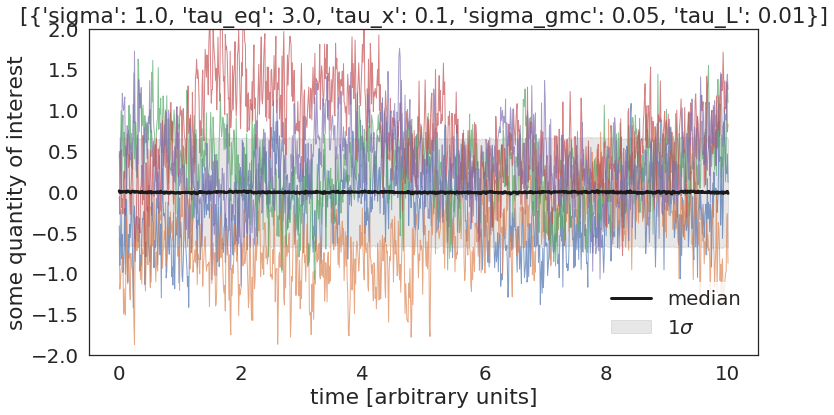

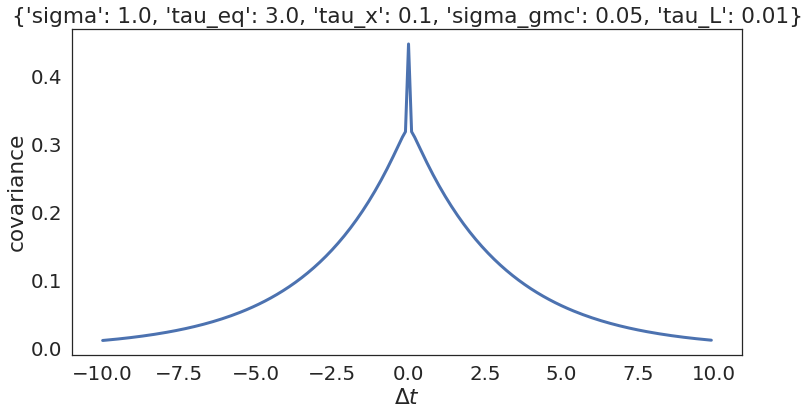

In [17]:
cls1 = simple_GP_sfh()
cls1.kernel = extended_regulator_model_kernel
cls1.plot_samples(sigma=1.0, tau_eq=3.0, tau_x = 0.1, sigma_gmc = 0.05, tau_L = 0.01, 
                  nsamp = 10000, random_seed=42,plim=2)
cls1.plot_kernel(sigma=1.0, tau_eq=3.0, tau_x = 0.1, sigma_gmc = 0.05, tau_L = 0.01)

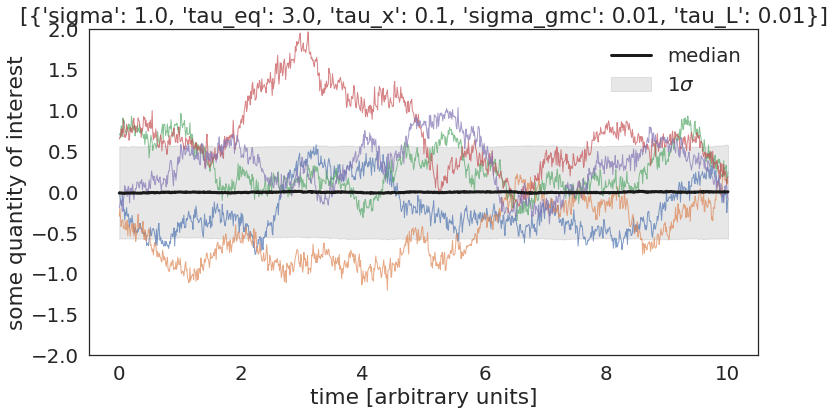

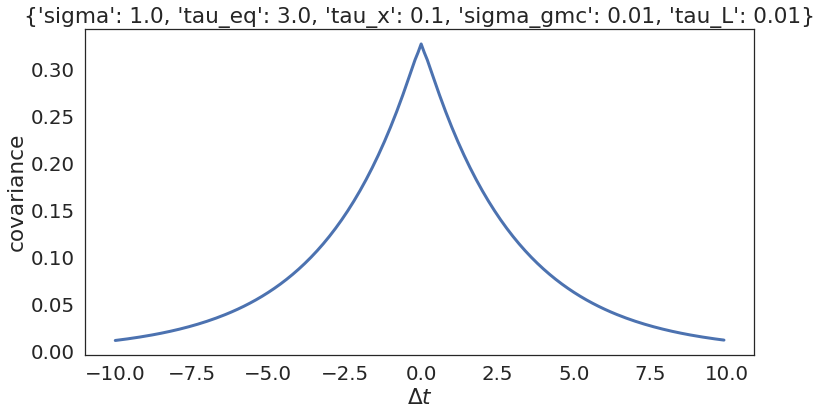

In [18]:
cls1 = simple_GP_sfh()
cls1.kernel = extended_regulator_model_kernel
cls1.plot_samples(sigma=1.0, tau_eq=3.0, tau_x = 0.1, sigma_gmc = 0.01, tau_L = 0.01, 
                  nsamp = 10000, random_seed=42,plim=2)
cls1.plot_kernel(sigma=1.0, tau_eq=3.0, tau_x = 0.1, sigma_gmc = 0.01, tau_L = 0.01)

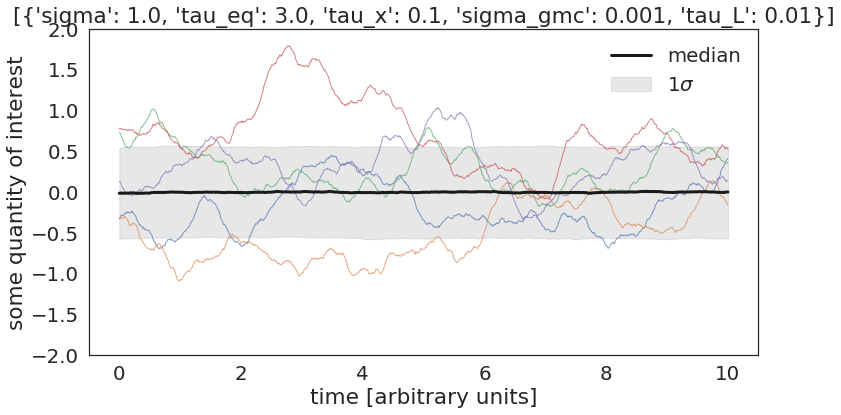

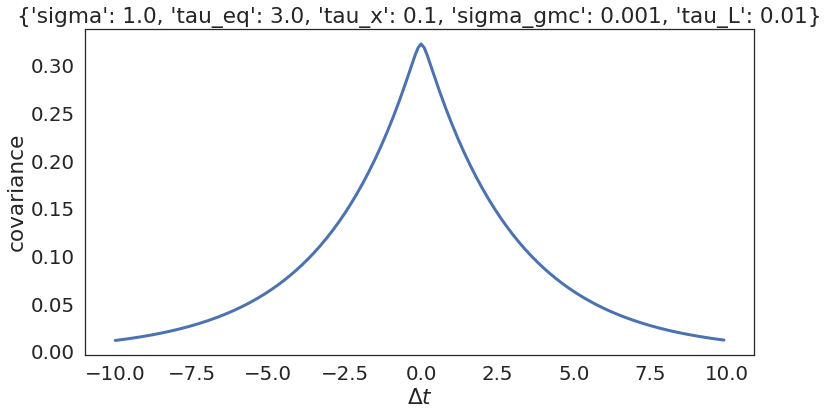

In [19]:
# in the case where the GMCs don't contribute much, this goes back to the regulator model result

cls1 = simple_GP_sfh()
cls1.kernel = extended_regulator_model_kernel
cls1.plot_samples(sigma=1.0, tau_eq=3.0, tau_x = 0.1, sigma_gmc = 0.001, tau_L = 0.01, 
                  nsamp = 10000, random_seed=42,plim=2)
cls1.plot_kernel(sigma=1.0, tau_eq=3.0, tau_x = 0.1, sigma_gmc = 0.001, tau_L = 0.01)

# Now let's try the special cases from Tacchella, Caplar & Forbes 2020

https://arxiv.org/pdf/2006.09382.pdf

(these are not implemented exactly as in the paper, I've just eyeballed the numbers from figure 7. I'll do a more rigorous implementation once i've fixed checking for bugs in the code)

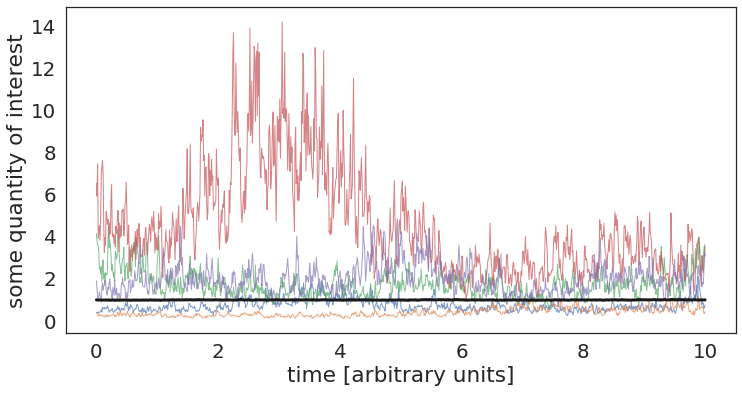

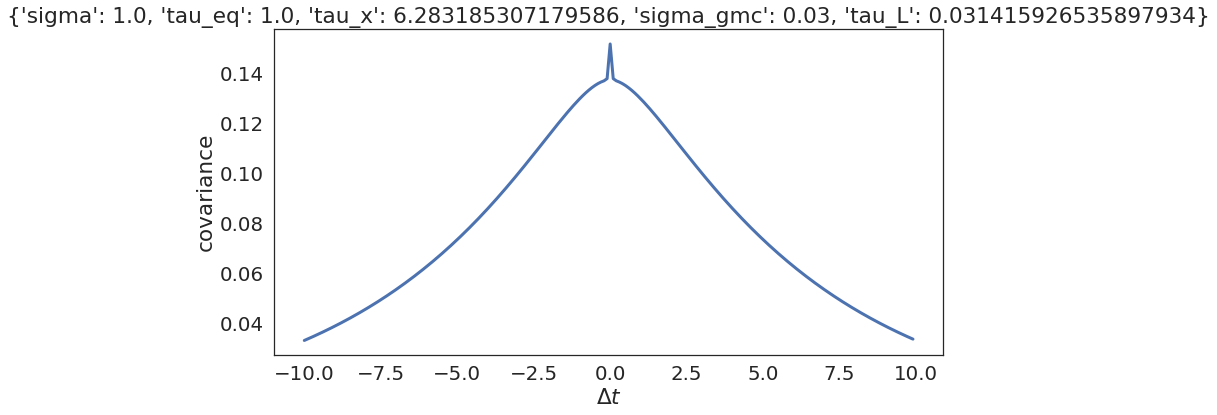

In [20]:
# Case 1: Dwarf

case1 = simple_GP_sfh()
case1.kernel = extended_regulator_model_kernel
case1.plot_samples(sigma=1.0, tau_eq=1.0, tau_x = 2*np.pi*1.0, sigma_gmc = 0.03, tau_L = 2*np.pi*0.005, 
                  nsamp = 10000, random_seed=42,plim=2, plotlog=True)
case1.plot_kernel(sigma=1.0, tau_eq=1.0, tau_x = 2*np.pi*1.0, sigma_gmc = 0.03, tau_L = 2*np.pi*0.005)

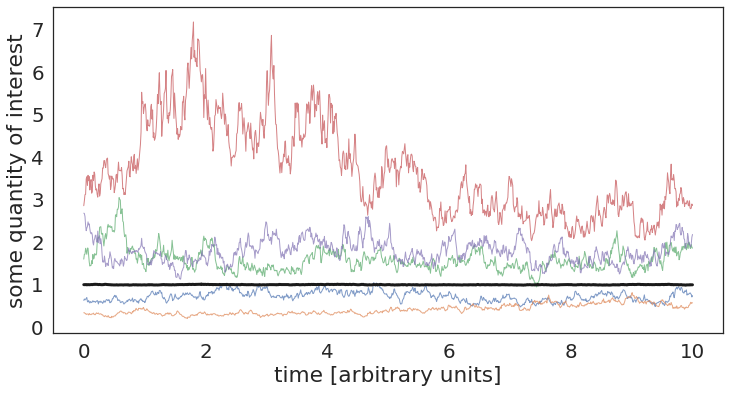

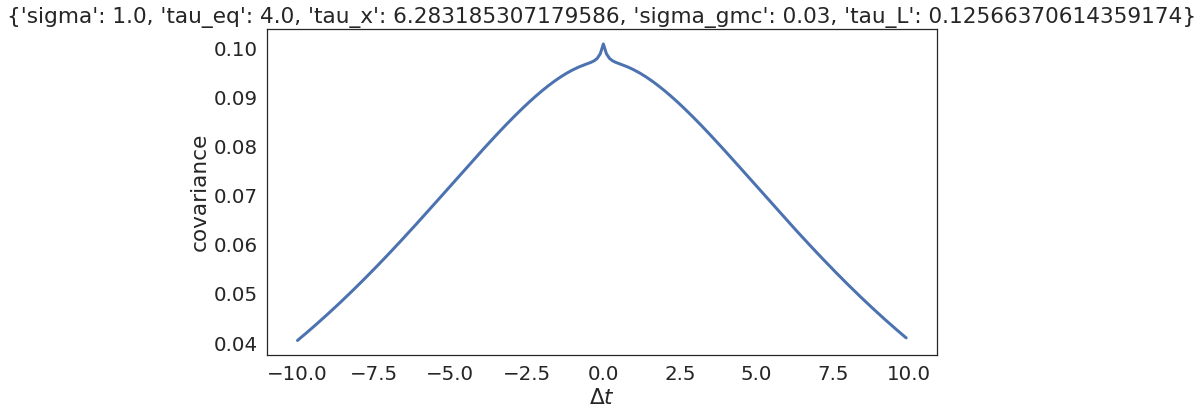

In [21]:
# Case 2: MW

case2 = simple_GP_sfh()
case2.kernel = extended_regulator_model_kernel
case2.plot_samples(sigma=1.0, tau_eq=4.0, tau_x = 2*np.pi*1.0, sigma_gmc = 0.03, tau_L = 2*np.pi*0.02, 
                  nsamp = 10000, random_seed=42,plim=2, plotlog=True)
case2.plot_kernel(sigma=1.0, tau_eq=4.0, tau_x = 2*np.pi*1.0, sigma_gmc = 0.03, tau_L = 2*np.pi*0.02)

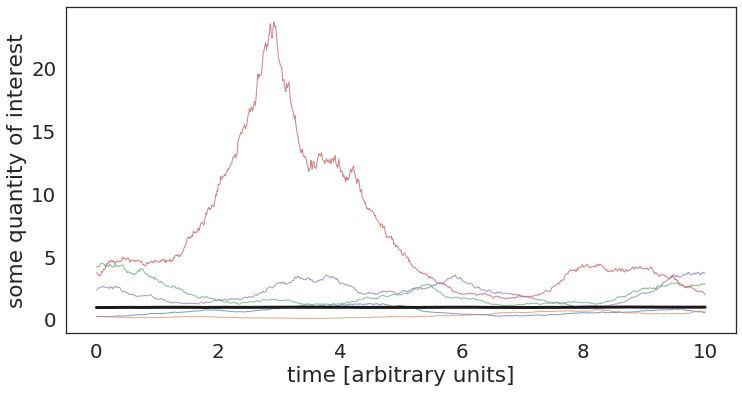

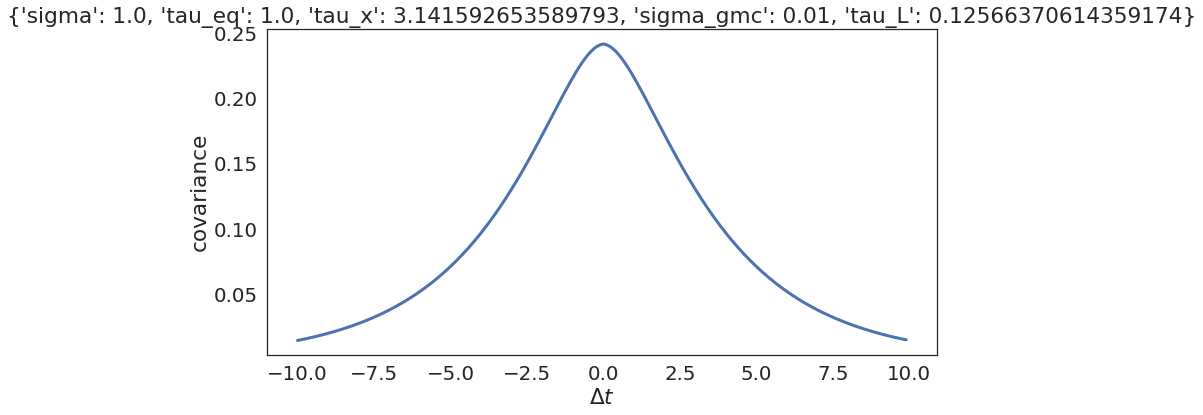

In [22]:
# Case 3: Cosmic Noon

case3 = simple_GP_sfh()
case3.kernel = extended_regulator_model_kernel
case3.plot_samples(sigma=1.0, tau_eq=1.0, tau_x = 2*np.pi*0.5, sigma_gmc = 0.01, tau_L = 2*np.pi*0.02, 
                  nsamp = 10000, random_seed=42,plim=2, plotlog=True)
case3.plot_kernel(sigma=1.0, tau_eq=1.0, tau_x = 2*np.pi*0.5, sigma_gmc = 0.01, tau_L = 2*np.pi*0.02)

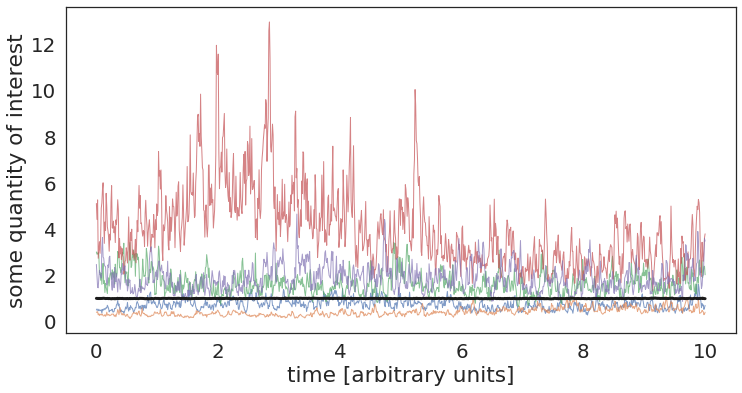

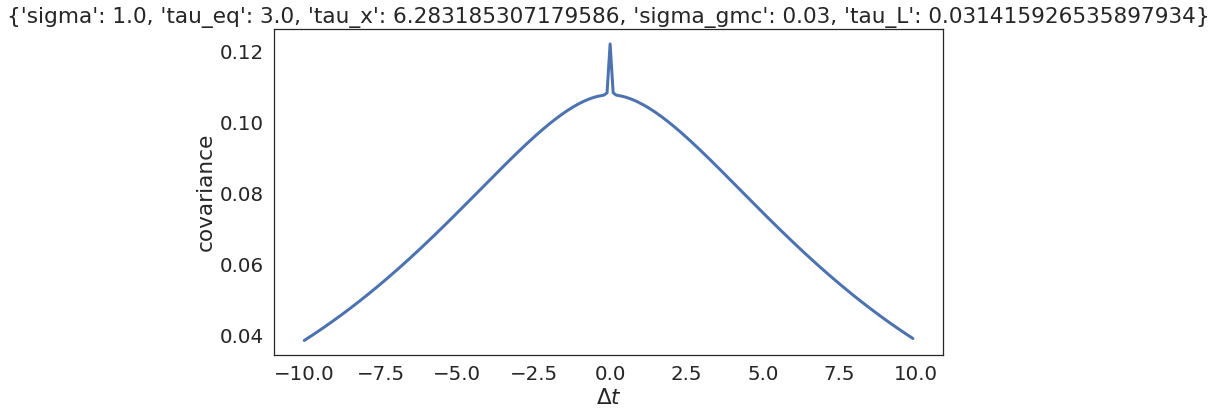

In [23]:
# Case 4: High-z

case4 = simple_GP_sfh()
case4.kernel = extended_regulator_model_kernel
case4.plot_samples(sigma=1.0, tau_eq=3.0, tau_x = 2*np.pi*1.0, sigma_gmc = 0.03, tau_L = 2*np.pi*0.005, 
                  nsamp = 10000, random_seed=42,plim=2, plotlog=True)
case4.plot_kernel(sigma=1.0, tau_eq=3.0, tau_x = 2*np.pi*1.0, sigma_gmc = 0.03, tau_L = 2*np.pi*0.005)

# Some timing experiments:

(since the covariane matrix is computed only the first time, subsequent sampling of the GPs should be blazing fast. checking the scaling here.)

In [24]:
# Case 4: High-z

case4 = simple_GP_sfh()
case4.kernel = extended_regulator_model_kernel

print('intialization and computing the covariance matrix')
%timeit samples = case4.sample_kernel(nsamp = 100, random_seed=42, sigma=1.0, tau_eq=3.0, tau_x = 2*np.pi*1.0, sigma_gmc = 0.03, tau_L = 2*np.pi*0.005)

print('subsequent sampling: n=100')
%timeit samples = case4.sample_kernel(nsamp = 100, random_seed=42, sigma=1.0, tau_eq=3.0, tau_x = 2*np.pi*1.0, sigma_gmc = 0.03, tau_L = 2*np.pi*0.005)

print('subsequent sampling: n=1000')
%timeit samples = case4.sample_kernel(nsamp = 1000, random_seed=42, sigma=1.0, tau_eq=3.0, tau_x = 2*np.pi*1.0, sigma_gmc = 0.03, tau_L = 2*np.pi*0.005)

print('subsequent sampling: n=10000')
%timeit samples = case4.sample_kernel(nsamp = 10000, random_seed=42, sigma=1.0, tau_eq=3.0, tau_x = 2*np.pi*1.0, sigma_gmc = 0.03, tau_L = 2*np.pi*0.005)

print('subsequent sampling: n=100000')
%timeit samples = case4.sample_kernel(nsamp = 100000, random_seed=42, sigma=1.0, tau_eq=3.0, tau_x = 2*np.pi*1.0, sigma_gmc = 0.03, tau_L = 2*np.pi*0.005)

intialization and computing the covariance matrix
131 ms ± 15.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
subsequent sampling: n=100
125 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
subsequent sampling: n=1000
144 ms ± 2.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
subsequent sampling: n=10000
488 ms ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
subsequent sampling: n=100000
3.58 s ± 20.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


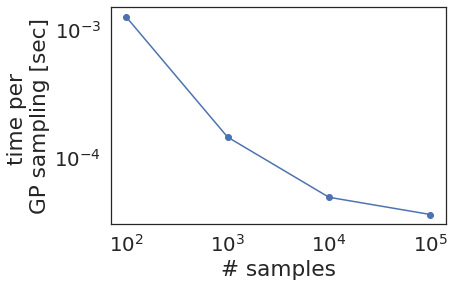

In [29]:
nsamp = np.array([1e2,1e3,1e4,1e5])
nsamp_times = np.array([125e-3, 144e-3, 488e-3, 3.58])
plt.plot(nsamp, nsamp_times/nsamp,'o-')
plt.xscale('log');plt.yscale('log')
plt.xlabel('# samples')
plt.ylabel('time per \nGP sampling [sec]')
plt.show()

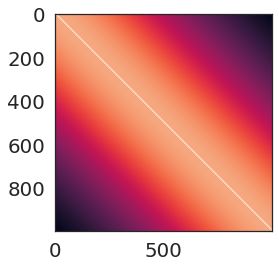

In [25]:
plt.imshow(case4.covariance_matrix)
plt.show()